In [7]:
import os

import numpy as np
import cupy as cp
from himalaya.backend import set_backend
from himalaya.ridge import Ridge
from himalaya.scoring import r2_score
from matplotlib import pyplot as plt
from sklearn import config_context
from sklearn.metrics import make_scorer
from sklearn.model_selection import ValidationCurveDisplay, validation_curve, LearningCurveDisplay, learning_curve

from compare_variance_residual.simulated.simulation import generate_dataset

In [2]:
# Custom R2 scoring function (with CuPy compatibility)
def custom_r2_scorer(estimator, X, y):
    import cupy as cp
    from sklearn.metrics import r2_score

    # Convert CuPy array back to NumPy for scoring
    y_pred = estimator.predict(X)
    r2_scores = r2_score(y, y_pred, multioutput='raw_values')
    return float(cp.mean(r2_scores))

In [15]:
set_backend("cupy", on_error='warn')
os.environ["SCIPY_ARRAY_API"] = "1"

feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    1/3, 1/3, 1/3
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 100
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-4, 4, 10)
param_name = "alpha"
param_range = alphas

In [16]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise_scalar)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Ridge or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_solvers.py:59: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 1 < 200). Using a linear kernel in himalaya.kernel_ridge.KernelRidge or himalaya.kernel_ridge.solve_kernel_ridge_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
/home/leo/PycharmProjects/

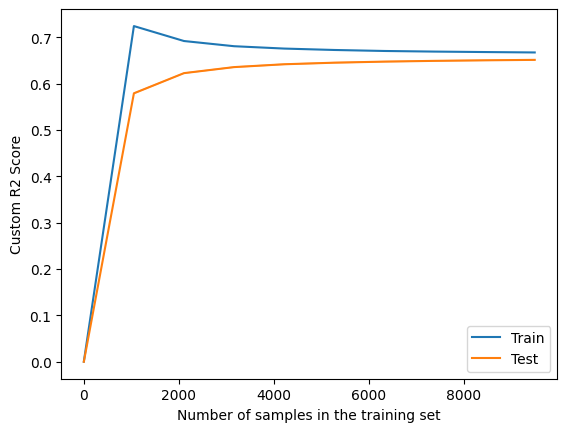

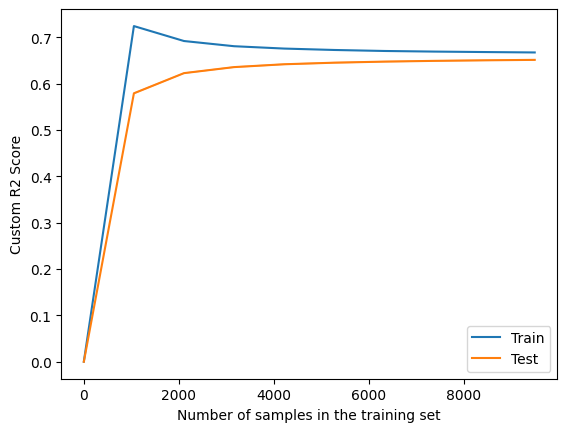

In [17]:
with config_context(array_api_dispatch=True):
    display = LearningCurveDisplay.from_estimator(
        Ridge(), Xs_train[0], Y_train, cv=cv, scoring=custom_r2_scorer,
        train_sizes=[int(num) for num in np.linspace(1, min(9500, Xs_train[0].shape[0])
, 10)],
        score_name="Custom R2 Score"
    )
    display.plot()
    plt.show()

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Ridge or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Ridge or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `s

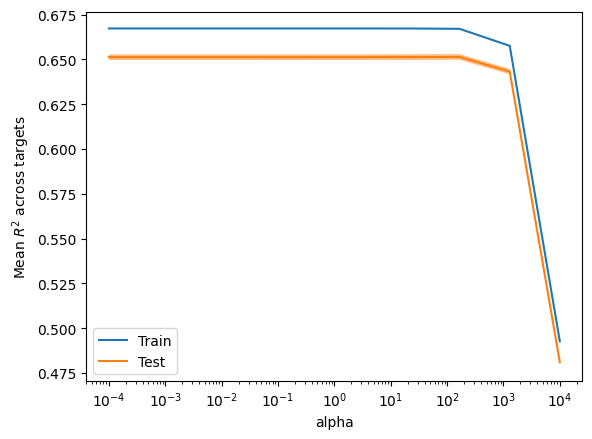

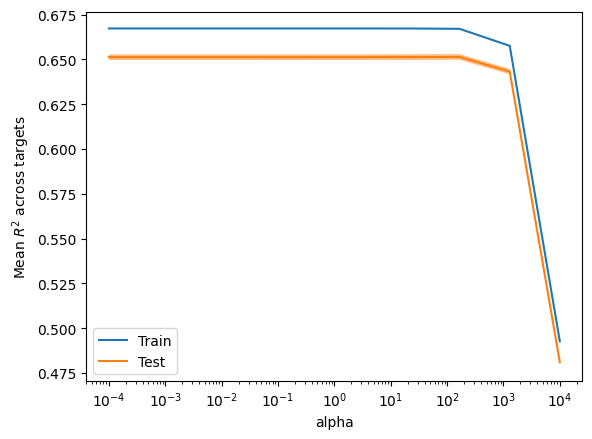

In [19]:
with config_context(array_api_dispatch=True):
    display = ValidationCurveDisplay.from_estimator(
        Ridge(), Xs_train[0], Y_train,
        param_name=param_name,
        param_range=param_range,
        score_name=r"Mean $R^2$ across targets",
        cv=cv, scoring=custom_r2_scorer
    )
    display.plot()
    plt.show()